In [14]:
import librosa
import librosa.display
import diddy.common as common
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import math

In [15]:
%matplotlib widget

In [16]:
start_second = 18 * 60
end_second = 22 * 60
wav_bytes, sr, skipped_bytes = common.load_sysk("20230321-The Tragic Tale of Floyd Collins", start_second=start_second, end_second=end_second)

[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


In [17]:
print(f'#bytes: {len(wav_bytes)}, #seconds: {end_second-start_second}, sample_rate: {sr}/s, #skipped_bytes: {skipped_bytes}')

#bytes: 3840000, #seconds: 240, sample_rate: 16000/s, #skipped_bytes: 17280000


In [18]:
print(skipped_bytes / sr /60)

18.0


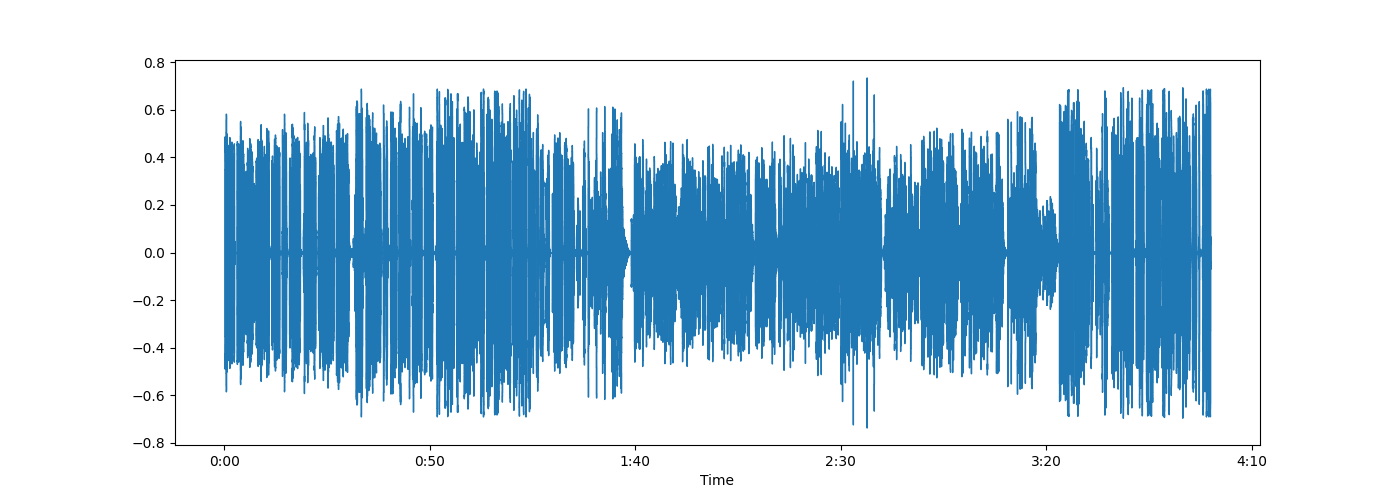

In [19]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(wav_bytes, sr=sr)

In [20]:
intervals_raw = librosa.effects.split(wav_bytes)
# print(intervals_raw[:3])
print(intervals_raw)

[[      0   42496]
 [  46592  221184]
 [ 221696  246784]
 [ 250368  489472]
 [ 493568  497664]
 [ 498688  612352]
 [ 615936  641024]
 [ 644096  674816]
 [ 675328 1225728]
 [1227264 1271296]
 [1273856 1390080]
 [1392128 1408512]
 [1409024 1409536]
 [1410048 1581056]
 [1581568 2062848]
 [2063360 2560000]
 [2563072 3044864]
 [3046912 3451392]
 [3451904 3803136]
 [3803648 3840000]]


In [21]:
# intervals = [(x/sr, y/sr) for [x,y] in intervals_raw]
intervals = []
raw_start_idx = intervals_raw[0][0]
is_zero_start = raw_start_idx == 0
if not is_zero_start:
    intervals.append([0, raw_start_idx - 1])
for x in intervals_raw:
    intervals.append(list(x))

In [22]:
intervals_dur = [(x, y, (y - x)/ 16000) for (x,y) in intervals]
print(intervals_dur)

[(0, 42496, 2.656), (46592, 221184, 10.912), (221696, 246784, 1.568), (250368, 489472, 14.944), (493568, 497664, 0.256), (498688, 612352, 7.104), (615936, 641024, 1.568), (644096, 674816, 1.92), (675328, 1225728, 34.4), (1227264, 1271296, 2.752), (1273856, 1390080, 7.264), (1392128, 1408512, 1.024), (1409024, 1409536, 0.032), (1410048, 1581056, 10.688), (1581568, 2062848, 30.08), (2063360, 2560000, 31.04), (2563072, 3044864, 30.112), (3046912, 3451392, 25.28), (3451904, 3803136, 21.952), (3803648, 3840000, 2.272)]


In [23]:
def ltes(tup, s):
    return tup[2] <= s

def gtes(tup, s):
    return tup[2] >= s

def all_rules(tup):
    return ltes(tup, 25) and gtes(tup, 5)

intervals_noncon = [x for x in filter(all_rules,intervals_dur)]
print(intervals_noncon)

[(46592, 221184, 10.912), (250368, 489472, 14.944), (498688, 612352, 7.104), (1273856, 1390080, 7.264), (1410048, 1581056, 10.688), (3451904, 3803136, 21.952)]


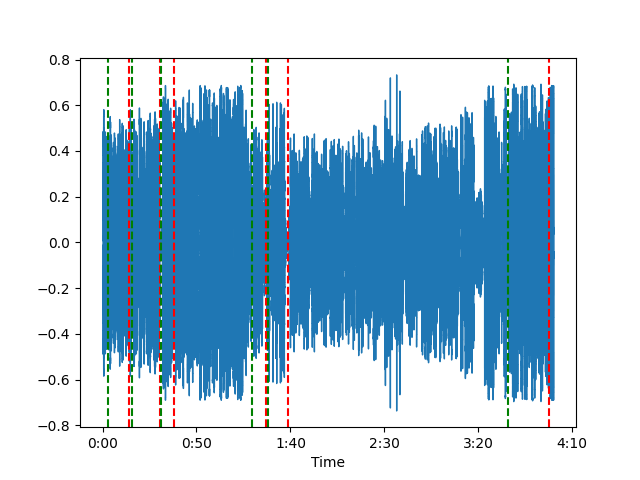

In [24]:
plt.figure('waveshow')
plt.clf()
librosa.display.waveshow(wav_bytes, sr=sr)
for start,end,_ in intervals_noncon:
    plt.axvline(x=start/sr, color='green', linestyle='--',data=(wav_bytes,[]))
    plt.axvline(x=end/sr, color='red', linestyle='--')
plt.show()

In [25]:
# plt.figure('melspectrogram')
# plt.clf()
# sgram = librosa.stft(wav_bytes)
# sgram_mag, _ = librosa.magphase(sgram)
# mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
# mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
# sgram_plot = librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
# # plt.colorbar(format='%+2.0f dB')
# plt.show()

18:03-18:14 (10.91s)


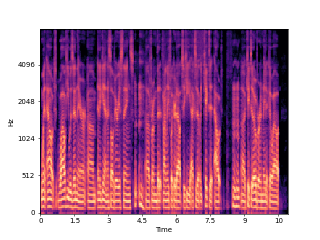

---

18:16-18:31 (14.94s)


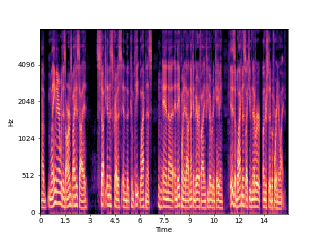

---

18:32-18:39 (7.10s)


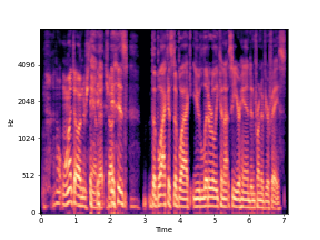

---

19:20-19:27 (7.26s)


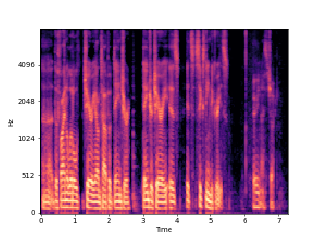

---

19:29-19:39 (10.69s)


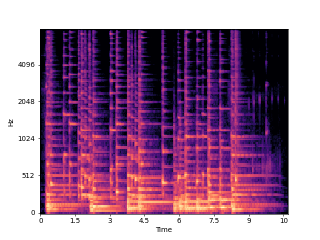

---

21:36-21:58 (21.95s)


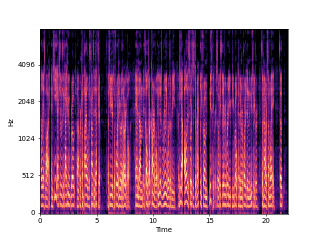

---

skipped:: 0/6


In [26]:
import math
lenset = set()
skip_count = 0

def zero_pad(x, n):
    y = x
    while n > 0:
        n = n - 1
        y = "0" + y
    return y

def to_2char_int(x):
    return zero_pad(x, 2 - len(x))

def index_to_timestamp(i):
    s_dec = i / sr
    m = math.floor(s_dec / 60)
    s = math.ceil(s_dec - (m * 60))
    return f'{to_2char_int(str(m))}:{to_2char_int(str(s))}'

def is_similar_len(len_it):
    for len_prime in lenset:
        if (abs(len_it - len_prime) / max(len_it, len_prime)) < 0.01:
            return True
    return False

for start, end, duration in intervals_noncon:
    slicee = wav_bytes[start:end]
    if is_similar_len(duration):
        skip_count = skip_count + 1
    else:
        lenset.add(duration)
        print(f'{index_to_timestamp(start + skipped_bytes)}-{index_to_timestamp(end + skipped_bytes)} ({duration:.2f}s)')
        ipd.display(ipd.Audio(slicee, rate=sr))
        plt.figure(f'melspectrogram_{start}', dpi=50)
        plt.clf()
        sgram = librosa.stft(slicee)
        sgram_mag, _ = librosa.magphase(sgram)
        mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        sgram_plot = librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
        # plt.colorbar(format='%+2.0f dB')
        plt.show()
        print(f'---\n')

print(f'skipped:: {skip_count}/{len(intervals_noncon)}')